# Neuro-Fuzzy Classification of MNIST
In this notebook a neuro-fuzzy classifier will be trained and evaluated on the MNIST dataset. No feature reductions techniques will be used, the intent is to provide a baseline performance to compare to other techniques.

In [1]:
import gzip
import numpy as np

def load_data(filename, dims):
    with gzip.open(filename, "rb") as infile:
        # consume magic number
        infile.read(4)
        # consume dimensions data
        infile.read(4 * len(dims))

        return np.frombuffer(infile.read(np.prod(dims)), dtype=np.uint8).reshape(dims)

# training data
train_images = load_data("data/train-images-idx3-ubyte.gz", [60000, 28, 28])
train_labels = load_data("data/train-labels-idx1-ubyte.gz", [60000])

# testing data
test_images = load_data("data/t10k-images-idx3-ubyte.gz", [10000, 28, 28])
test_labels = load_data("data/t10k-labels-idx1-ubyte.gz", [10000])

The MNIST data is loaded into memory as NumPy arrays.

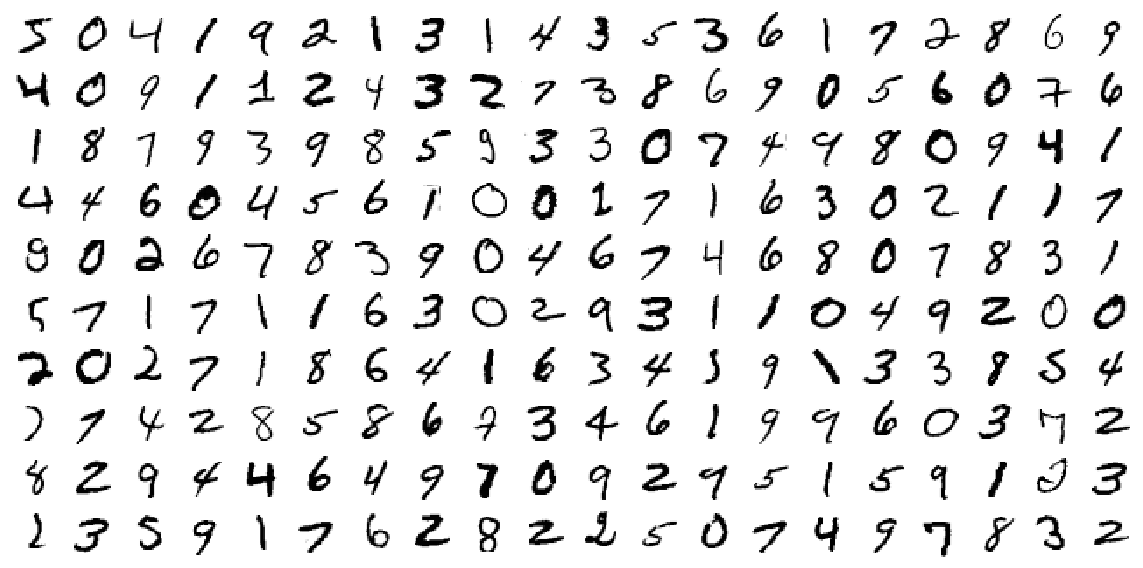

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
fig, ax_array = plt.subplots(10, 20, figsize=(16, 8))
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(train_images[i,:,:], cmap="Greys", interpolation="none")

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

Samples from the training images are displayed above to ensure the data was loaded correctly.

{'whiskers': [<matplotlib.lines.Line2D at 0x7f1c99c75be0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1c99c002b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1c99c75668>],
 'medians': [<matplotlib.lines.Line2D at 0x7f1c99c00940>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f1c99c00c88>],
 'means': []}

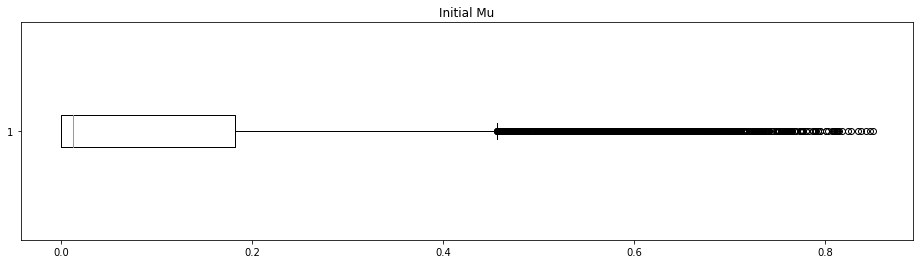

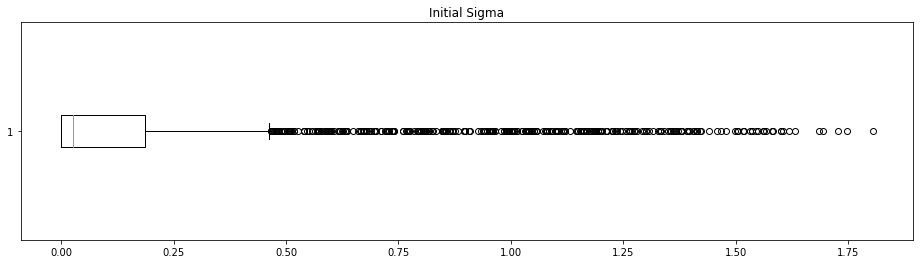

In [3]:
import os
import pickle
import skfuzzy as skf

_cache_dir = "cache/params.pickle"
_ignore_cache = False


# compute sigma parameter
def compute_sigmas(data, memberships, centers):
    mask = np.any(memberships >= 1.0, axis=0)
    data = data[:,~mask]
    memberships = memberships[:,~mask]
    
    data = np.expand_dims(data, axis=0)
    memberships = np.expand_dims(memberships, axis=1)
    centers = np.expand_dims(centers, axis=2)
    
    return np.mean(np.sqrt(-np.square(data - centers) / (2 * np.log(memberships))), axis=2)


# generate the parameters for the fuzzy classifier
def gen_params(data, c, m):
    if not os.path.isfile(_cache_dir) or _ignore_cache:
        centers, memberships, u0, d, jm, p, fpc = skf.cmeans(
            data.T, 10, 1.1, 1e-8, 1000, seed=0)
        sigmas = compute_sigmas(data.T, memberships, centers)
        pickle.dump((centers, sigmas), open(_cache_dir, "wb"))
    
    else:
        centers, sigmas = pickle.load(open(_cache_dir, "rb")) 
    
    return centers, sigmas


# initial parameters for use in model
init_mu, init_sigma = gen_params(train_images.reshape(-1, 784), 10, 1.1)

plt.figure(figsize=(16, 4))
plt.title("Initial Mu")
plt.boxplot(init_mu.reshape(-1), vert=False)

plt.figure(figsize=(16, 4))
plt.title("Initial Sigma")
plt.boxplot(init_sigma.reshape(-1), vert=False)

The initial values for mu and sigma are generated (or loaded from the disk) and boxplots are displayed above.

In [4]:
def processed_data():
    train_x = train_images.astype(np.float) / 255
    train_y = np.zeros((60000,10))
    train_y[np.arange(60000), train_labels] = 1
    
    test_x = test_images.astype(np.float) / 255
    test_y = np.zeros((10000,10))
    test_y[np.arange(10000), test_labels] = 1

    return (train_x, train_y), (test_x, test_y)


(train_x, train_y), (test_x, test_y) = processed_data()

This function formats the training data by rescaling the images and creating one-hot vectors for the target data.

## Building the Network
The code that defines the network structure written below. A custom layer was created for the gaussian membership function. Additionally, the product t-norm is computed and normalized in special way to prevent numerical underflow.

The product t-norm and normalization layer. 
\begin{align}
\ f_i & = \frac{1}{f_{max}}\prod_{j=1}^N m_{i,j} \\
\ f_i & = exp\Big({ln\Big(\frac{1}{f_{max}}\prod_{j=1}^N m_{i,j}\Big)}\Big) \\
\ f_i & = exp\Big({\sum_{j=1}^N ln(m_{i,j})} - ln(f_{max})\Big) \\
\end{align}

In [5]:
import keras
import keras.layers as layers
import keras.models as models
from keras import backend as K


# custom layer for gauss membership function
class GaussMembership(layers.Layer):
    
    def __init__(self, num_rules, epsilon=1e-8, **kwargs):
        self.epsilon = epsilon
        self.num_rules = num_rules
        super(GaussMembership, self).__init__(**kwargs)
        
        
    def build(self, input_shape):
        self.mu = self.add_weight(
            name="mu",
            shape=(self.num_rules, input_shape[1]),
            initializer=keras.initializers.Zeros(),
            trainable=True)
        self.sigma = self.add_weight(
            name="sigma",
            shape=(self.num_rules, input_shape[1]),
            initializer=keras.initializers.Ones(),
            constraint=keras.constraints.NonNeg(),
            trainable=True)
        super(GaussMembership, self).build(input_shape)
    
    
    def call(self, x):
        x = K.expand_dims(x, axis=1)
        x = K.square((x - self.mu) / (self.sigma + self.epsilon))
        return K.exp(-0.5 * x)
    
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_rules, input_shape[1])
    

# create the model with the given parameters
def create_model(init_mu, init_sigma, num_rules=10):
    # define the models input
    inputs = layers.Input(shape=(28, 28,))
    reshaped = layers.Reshape((784,))(inputs)

    # apply the membership function
    membership = GaussMembership(
        num_rules, weights=[init_mu, init_sigma])(reshaped)

    def log_prod(x):
        x = K.sum(K.log(x + 1e-8), axis=2)
        x = x - K.max(x, axis=1, keepdims=True)
        return K.exp(x)

    fstrength = layers.Lambda(lambda x:
        log_prod(x))(membership)
    
    outputs = layers.Dense(10, activation="sigmoid")(fstrength)
    return models.Model(inputs=inputs, outputs=outputs)

Using TensorFlow backend.


This code defines the model in keras.

In [6]:
import tensorflow as tf


def plot_activations(model, inputs):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for layer in model.layers:
            activation_val = sess.run(
                layer.output,
                feed_dict={model.input:inputs})
            
            plt.figure(figsize=(16, 4))
            plt.title(layer)
            plt.boxplot(activation_val.reshape(-1), vert=False)
            
            
def plot_gradients(model, inputs):
    gradient_fn = K.gradients(model.output, model.trainable_weights)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        gradients = sess.run(
            gradient_fn,
            feed_dict={model.input:inputs})
            
    for param, gradient in zip(model.trainable_weights, gradients):
        plt.figure(figsize=(16, 4))
        plt.title(param)
        plt.boxplot(gradient.reshape(-1), vert=False)

The functions above are written using tensorflow in order to view the intermediate activations and gradients in a model.

In [7]:
fcm_model = create_model(init_mu, init_sigma)
fcm_model.compile(loss="binary_crossentropy", optimizer="sgd")

#plot_activations(fcm_model, train_x[:64])

In [8]:
def plot_prod_layer(model, inputs):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        membership_val = sess.run(
            model.layers[2].output,
            feed_dict={model.input:inputs})

    plt.figure(figsize=(16, 4))
    plt.title("Memberships")
    plt.boxplot(membership_val.reshape(-1), vert=False)

    logsum = np.sum(np.log(membership_val + 1e-8), axis=2)

    plt.figure(figsize=(16, 4))
    plt.title("Log-Sum")
    plt.boxplot(logsum.reshape(-1), vert=False)

    normalized = logsum - np.max(logsum, axis=1, keepdims=True)

    plt.figure(figsize=(16, 4))
    plt.title("Normalized Log-Sum")
    plt.boxplot(normalized.reshape(-1), vert=False)

    fstrength = np.exp(normalized)

    plt.figure(figsize=(16, 4))
    plt.title("Firing Strength")
    plt.boxplot(fstrength.reshape(-1), vert=False)

    
#plot_prod_layer(fcm_model, train_x[:64])

The activations of each layer are shown in the boxplots above. The firing strength of the rules seem to be exclusively ones. I am unsure as to why this is, but it will likely cause a problem with training.

In [9]:
#plot_gradients(fcm_model, train_x[:128])

Plotted above are the models gradients.

In [10]:
def plot_history(history):
    plt.figure(figsize=(16, 8))
    plt.title("Loss")
    plt.plot(history.history["loss"], c="b")
    plt.plot(history.history["val_loss"], c="r")

    plt.figure(figsize=(16, 8))
    plt.title("Accuracy")
    plt.plot(history.history["categorical_accuracy"], c="b")
    plt.plot(history.history["val_categorical_accuracy"], c="r")

# fcm_model.compile(
#     optimizer="sgd",
#     loss="binary_crossentropy",
#     metrics=[keras.metrics.categorical_accuracy])

# fcm_history = fcm_model.fit(
#     x=train_x,
#     y=train_y,
#     batch_size=64,
#     epochs=100,
#     validation_data=(test_x, test_y),
#     verbose=0)

# plot_history(fcm_history)

When initialized using the parameters from FCM, the model does not seem to learn at all. Both accuracy and loss seem to completely plateau. This is most likely due to numerous small values in the sigma parameters but will need to be investigated in more depth later.

In [16]:
centers_model = create_model(init_mu, np.ones((10,784)))

# centers_model.compile(
#     optimizer="adam",
#     loss="binary_crossentropy",
#     metrics=[keras.metrics.categorical_accuracy])

# centers_history = centers_model.fit(
#     x=train_x,
#     y=train_y,
#     batch_size=64,
#     epochs=50,
#     validation_data=(test_x, test_y),
#     verbose=1)

# plot_history(centers_history)

Using an array of ones in place of the initial sigma values allows the network to train and reach an accuracy of around 70%. Extrapolating from the graph, better performance can be achieved by letting it train longer.

In [ ]:
sigmas_model = create_model(np.zeros((10,784)), init_sigma)

# sigmas_model.compile(
#     optimizer="sgd",
#     loss="binary_crossentropy",
#     metrics=[keras.metrics.categorical_accuracy])

# sigmas_history = sigmas_model.fit(
#     x=train_x,
#     y=train_y,
#     batch_size=64,
#     epochs=100,
#     validation_data=(test_x, test_y),
#     verbose=0)

# plot_history(sigmas_history)

Using the zeros for the mu values, and the initial sigma values the network encounters the same problem where it is unable to train.

In [ ]:
ones_zeros_model = create_model(np.zeros((10,784)), np.ones((10,784)))

# ones_zeros_model.compile(
#     optimizer="sgd",
#     loss="binary_crossentropy",
#     metrics=[keras.metrics.categorical_accuracy])

# ones_zeros_history = ones_zeros_model.fit(
#     x=train_x,
#     y=train_y,
#     batch_size=64,
#     epochs=100,
#     validation_data=(test_x, test_y),
#     verbose=0)

# plot_history(ones_zeros_history)

Surprisingly, using zeros for mu and ones for sigma as initial values seems to give the best results so far. The network exceeds 80% accuracy and shows no signs of overfitting. The network does seem to take a very long time to train, taking 100 epochs to reach ~85% accuracy.

In [21]:
model = create_model(init_mu, np.ones((10,784)))

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[keras.metrics.categorical_accuracy])

history = model.fit(
    x=train_x,
    y=train_y,
    batch_size=64,
    epochs=50,
    validation_data=(test_x, test_y),
    verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 58us/step - loss: 0.4104 - categorical_accuracy: 0.2533 - val_loss: 0.2905 - val_categorical_accuracy: 0.3845
Epoch 2/50
60000/60000 [==============================] - 3s 50us/step - loss: 0.2640 - categorical_accuracy: 0.4919 - val_loss: 0.2387 - val_categorical_accuracy: 0.6201
Epoch 3/50
60000/60000 [==============================] - 3s 49us/step - loss: 0.2158 - categorical_accuracy: 0.6862 - val_loss: 0.1858 - val_categorical_accuracy: 0.7500
Epoch 4/50
60000/60000 [==============================] - 3s 50us/step - loss: 0.1694 - categorical_accuracy: 0.7865 - val_loss: 0.1544 - val_categorical_accuracy: 0.8402
Epoch 5/50
60000/60000 [==============================] - 3s 50us/step - loss: 0.1449 - categorical_accuracy: 0.8441 - val_loss: 0.1359 - val_categorical_accuracy: 0.8509
Epoch 6/50
60000/60000 [==============================] - 3s 50us/step - loss: 0.1283 - categor

60000/60000 [==============================] - 3s 48us/step - loss: 0.0449 - categorical_accuracy: 0.9403 - val_loss: 0.0542 - val_categorical_accuracy: 0.9221
Epoch 49/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.0447 - categorical_accuracy: 0.9403 - val_loss: 0.0547 - val_categorical_accuracy: 0.9221
Epoch 50/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.0445 - categorical_accuracy: 0.9406 - val_loss: 0.0545 - val_categorical_accuracy: 0.9201


Training Accuracy: 94.06%
Validation Accuracy: 92.57%


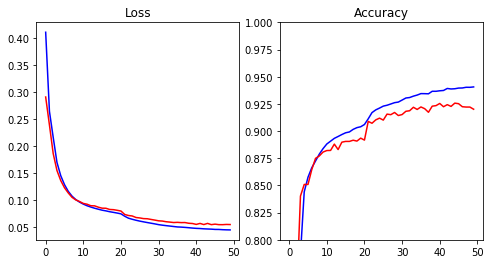

In [27]:
def summarize_history(history):
    print("Training Accuracy: {:.2%}".format(np.max(history.history["categorical_accuracy"])))
    print("Validation Accuracy: {:.2%}".format(np.max(history.history["val_categorical_accuracy"])))


fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
axes[0].set_title("Loss")
axes[0].plot(history.history["loss"], c="b")
axes[0].plot(history.history["val_loss"], c="r")

axes[1].set_title("Accuracy")
axes[1].set_ylim((0.8, 1))
axes[1].plot(history.history["categorical_accuracy"], c="b")
axes[1].plot(history.history["val_categorical_accuracy"], c="r") 

summarize_history(history)

Using the adam optimizer gives the best training results so far. The network starts to overfit somewhere between 10-20 epochs. This means the network won't have to be trained for hundreds of epochs.

In [ ]:
# ones_zeros_model = create_model(np.zeros((10,784)), np.ones((10,784)))

# ones_zeros_model.compile(
#     optimizer="adam",
#     loss="binary_crossentropy",
#     metrics=[keras.metrics.categorical_accuracy])

# adam_history = ones_zeros_model.fit(
#     x=train_x,
#     y=train_y,
#     batch_size=64,
#     epochs=20,
#     validation_data=(test_x, test_y),
#     verbose=0)

# summarize_history(adam_history)
# plot_history(adam_history)

Using the Adam optimizer, good results are achieved in only 20 epochs.

## Other Parameters
This investigates the model's performance with different numbers of rules.

In [ ]:
# for n in [20, 50, 100]:
#     model = create_model(np.zeros((n,784)), np.ones((n,784)), num_rules=n)

#     model.compile(
#         optimizer="adam",
#         loss="binary_crossentropy",
#         metrics=[keras.metrics.categorical_accuracy])

#     history = model.fit(
#         x=train_x,
#         y=train_y,
#         batch_size=64,
#         epochs=20,
#         validation_data=(test_x, test_y),
#         verbose=0)

#     print("{} Rules:".format(n))
#     summarize_history(history)
#     plot_history(history)